### Tool calling 

#### With `bind_tools`
Decide whether to save memories based on the conversation with the user.

In [1]:
from pydantic import BaseModel, Field

# Define the memory schema
class Memory(BaseModel):
    """ Format of memories extracted from the conversation. """
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

In [2]:
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
# Bind Memory schema as a tool to the model
model_with_tools = model.bind_tools([Memory])

In [45]:
from langchain_core.messages import HumanMessage

# Invoke the model with general conversation
output = model_with_tools.invoke([HumanMessage("Hi!")])
output.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [46]:
# Invoke the model with personal information, which should trigger the tool call
output = model_with_tools.invoke([HumanMessage("My name is Lance, I like to bike.")])
output.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  SaveMemory (call_sZG4bcHXxfTg2cXOC3Pd5DjV)
 Call ID: call_sZG4bcHXxfTg2cXOC3Pd5DjV
  Args:
    store_memories: True


In [101]:
output.tool_calls[0] 

{'name': 'SaveMemory',
 'args': {'store_memories': True},
 'id': 'call_sZG4bcHXxfTg2cXOC3Pd5DjV',
 'type': 'tool_call'}

#### With `Trustcall`

We can use [Trustcall](https://github.com/hinthornw/trustcall) as an extension of `bind_tools`.

Before, we used `tool_choice=`, to enforces use of the the schema tool that we passed. 

In the context of an agent, we want to allow the model to choose whether to use the tool or not!

So, we omit this. 

In [17]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    enable_inserts=True,
)

In [53]:
from langchain_core.messages import SystemMessage

# Create instruction for the extractor
instruction = """You are are a helpful assistant. You have access to a memory tool. First call the memory tool if any personal information is mentioned. Then, once the memories are saved, respond to the user's message naturally."""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction), HumanMessage("Hi!")]})

In [54]:
# Message from the model 
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [55]:
# The resulting schemas,if applicable (none in this case)
for m in result["responses"]: 
    print(m)

Now, let's invoke the extractor with a message that contains personal information. 

In [57]:
# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction), HumanMessage("My name is Lance, I like to bike.")]})

In [58]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_oT9UcXzM9FYrBPZKIdmRUN84)
 Call ID: call_oT9UcXzM9FYrBPZKIdmRUN84
  Args:
    content: User's name is Lance.
    context: User introduced themselves.
  Memory (call_RQvw2im33gvxHIqFcNVUlFNh)
 Call ID: call_RQvw2im33gvxHIqFcNVUlFNh
  Args:
    content: User likes to bike.
    context: User shared their hobbies.


In [96]:
result["messages"][0].tool_calls

[{'name': 'Memory',
  'args': {'content': 'User likes to bike in Marin Headlands.',
   'context': 'User shared their hobbies.'},
  'id': 'call_JegriWiqzOMwCuuVpZWw4shQ',
  'type': 'tool_call'},
 {'name': 'Memory',
  'args': {'content': 'User likes to go to bakeries.',
   'context': 'User shared their hobbies.'},
  'id': 'call_M4r7EzCAEAPdJhEexjpgSAth',
  'type': 'tool_call'}]

In [91]:
m.tool_calls

[{'name': 'Memory',
  'args': {'content': 'User likes to bike in Marin Headlands.',
   'context': 'User shared their hobbies.'},
  'id': 'call_JegriWiqzOMwCuuVpZWw4shQ',
  'type': 'tool_call'},
 {'name': 'Memory',
  'args': {'content': 'User likes to go to bakeries.',
   'context': 'User shared their hobbies.'},
  'id': 'call_M4r7EzCAEAPdJhEexjpgSAth',
  'type': 'tool_call'}]

In [59]:
# We can see the resulting memories that are resolved from the tool calls
for m in result["responses"]: 
    print(m.model_dump(mode="json"))


{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
{'content': 'User likes to bike.', 'context': 'User shared their hobbies.'}


In [60]:
# We'll save these memories, giving them an ID, key, and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': "User's name is Lance.",
   'context': 'User introduced themselves.'}),
 ('1',
  'Memory',
  {'content': 'User likes to bike.', 'context': 'User shared their hobbies.'})]

In [78]:
# Invoke the extractor with a follow-up message and pass in our existing memories
result = trustcall_extractor.invoke({"messages": [HumanMessage(content="I like to bike in Marin Headlands. I also like to go to bakeries.")], 
                                     "existing": existing_memories})

In [79]:
type(result)

dict

In [80]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_JegriWiqzOMwCuuVpZWw4shQ)
 Call ID: call_JegriWiqzOMwCuuVpZWw4shQ
  Args:
    content: User likes to bike in Marin Headlands.
    context: User shared their hobbies.
  Memory (call_M4r7EzCAEAPdJhEexjpgSAth)
 Call ID: call_M4r7EzCAEAPdJhEexjpgSAth
  Args:
    content: User likes to go to bakeries.
    context: User shared their hobbies.


In [71]:
# We can see the resulting memories that are resolved from the tool calls
for m in result["responses"]: 
    print(m.model_dump(mode="json"))


{'content': 'User likes to bike in Marin Headlands.', 'context': 'User shared their hobbies.'}
{'content': 'User likes to go to bakeries.', 'context': 'User shared their hobbies.'}


We make an update to `existing_memories`.

In [72]:
# We can see the resulting memories that are resolved from the tool calls
for m in result["response_metadata"]: 
    print(m)


{'id': 'call_eao9zMXBA9Cm5ERlZWTjdW8p', 'json_doc_id': '1'}
{'id': 'call_hU2zUDM3AJh2FHamY220d9m6'}


### React agent 

Decide whether to save memories based on the conversation with the user.

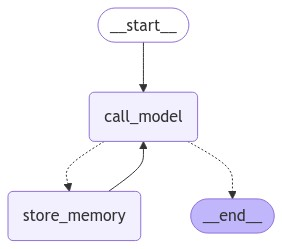

In [102]:
from IPython.display import Image, display

import uuid

from datetime import datetime
from dataclasses import dataclass

from typing_extensions import Annotated

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AnyMessage

from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

# Schema for storing memories
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    enable_inserts=True,
)

class State(MessagesState):
    extracted_memories: dict = {}

# Node definitions
def call_model(state: State, config: RunnableConfig, *, store: BaseStore) -> dict:

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    system_msg = f"""You are are a helpful assistant. You have access to a memory tool. 
    First call the memory tool if any personal information is mentioned in the below conversation. 
    Then, once the memories are saved, respond to the user's message naturally.  
    Use any existing memoried to personalize your responses.
    Here are your memories (it may be empty): {existing_memories}"""

    # Invoke the extractor with existing memories and the chat history
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + state["messages"], 
                                         "existing": existing_memories})

    # Trustcall output 
    trustcall_messages = result["messages"] 
    trustcall_memories = result["responses"]
    trustcall_memories_metadata = result["response_metadata"]

    return {"messages": trustcall_messages, "extracted_memories": result}

def store_memory(state: State, config: RunnableConfig, *, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Tool call to decide to save memories
    trustcall_results = state['extracted_memories']

    # List of tool calls
    trustcall_tool_calls = trustcall_results["messages"][0].tool_calls
    # List of memories that were extracted from the tool calls
    trustcall_memories = trustcall_results["responses"]
    # Metadata about the memories that were extracted from the tool calls
    trustcall_memories_metadata = trustcall_results["response_metadata"]

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(trustcall_memories, trustcall_memories_metadata):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

    # Tool message to confirm Trustcall outputs were saved to store
    trustcall_tool_confirmation = [
        ToolMessage(content=mem, tool_call_id=tc["id"])
        for tc, mem in zip(trustcall_tool_calls, trustcall_memories)
    ]

    return {"messages": trustcall_tool_confirmation}

# Conditional edge
def route_message(state: State):

    """Determine the next step based on the presence of tool calls."""

    # Get the last message
    msg = state['messages'][-1]

    # If there is a tool call, the model has decided to save memories
    if msg.tool_calls:
        # Direct to the store_memory node to save the memories
        return "store_memory"
    # Otherwise, finish; user can send the next message
    return END

# Create the graph + all nodes
builder = StateGraph(State)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_node(store_memory)
builder.add_edge("__start__", "call_model")
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
builder.add_edge("store_memory", "call_model")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [103]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================
Tool Calls:
  Memory (call_rWosGE2av1In75gmhjj9Zsb0)
 Call ID: call_rWosGE2av1In75gmhjj9Zsb0
  Args:
    content: User's name is Lance.
    context: User introduced themselves.
================================= Tool Message =================================

content="User's name is Lance." context='User introduced themselves.'
================================== Ai Message ==================================
Tool Calls:
  Memory (call_FJnl1K2S3tN3gaPTS5KtpPCV)
 Call ID: call_FJnl1K2S3tN3gaPTS5KtpPCV
  Args:
    content: User's name is Lance.
    context: User introduced themselves.
================================= Tool Message =================================

content="User's name is Lance." context='User introduced themselves.'
================================== Ai Message ===============================

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [30]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun! San Francisco has some beautiful routes for biking. Do you have a favorite trail or area you like to explore?


In [27]:
# User input 
input_messages = [HumanMessage(content="Today I went biking in Marin Headlands")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Today I went biking in Marin Headlands
================================== Ai Message ==================================

The Marin Headlands are stunning! The views of the Golden Gate Bridge and the ocean are incredible. Did you have a favorite spot or moment from your ride today?
